<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/nisar/Subsidence_NISAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# NISAR Application: Subsidence

### Corresponding Story Map: https://arcg.is/0PGi5f0

### I. How to create SAR quicklook images of subsidence?

* Useful Products:
* Useful Wavelengths:
* Instructions to View:

### II. How to interpret SAR images of subsidence?



## SAR Examples: California Oil Fields


The content of this notebook is as follows:

1. [Running the Notebook](#s1)
2. [Example 1](#s2)
3. [Example 2](#s3)
3. [References](#s4)




<a name="s1"></a>
## 1. Running the Notebook

- This Notebook has both "text" and "code" cells. The text cells have text descriptions about running the notebooks and data interpretation.
- Code cells are a light gray and a "play" button appears in the upper left corner when your mouse is hovered over the cell.
- To run the content in the code cells, **select the play button** in the upper left corner of each code cell or **press shift-enter**.

### Install Python Packages
This routine uses several python libaries. Some are already included in the Google Colab environment and others are installed and imported in the cell below. Downloading new python packages to this environment may take a few seconds to complete.

In [1]:
!pip install rasterio --quiet
!pip install geopandas --quiet

import rasterio as rio                      # Read and write geospatial raster data
from rasterio.plot import plotting_extent   # Returns plotting extent in format needed
import matplotlib.pyplot as plt             # Plotting, making graphs
import geopandas as gpd                     # Visualizing and importing geodata frames
import numpy as np                          # Numeric and mathematic functions
import math                                 # Access to mathematical functions
import getpass
import os
from osgeo import gdal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 37.6 MB/s eta 0:00:00


### Download the Data

Fetch UAVSAR geotiffs from the download links below with wget. The original UAVSAR data have been converted to cropped and subset geotiffs over the Station Fire perimeter.


In [2]:
!%%shell
!yes | add-apt-repository ppa:ubuntugis/ppa
!apt-get update
!apt-get install gdal-bin libgdal-dev
!C_INCLUDE_PATH=/usr/include/gdal CPLUS_INCLUDE_PATH=/usr/include/gdal python -m pip install GDAL=="$(gdal-config --version)"

/bin/bash: line 1: fg: no job control
PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu/ jammy main'
Description:
Official stable UbuntuGIS packages.


More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ppa
Adding repository.
Found existing deb entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding deb entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Found existing deb-src entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntugis-ubuntu-ppa.gpg with fingerprint 6B827C12C2D425E227EDCA75089EBE08314DF160
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/re

In [3]:
# Download data files from JPL website
username = getpass.getpass(prompt='Earthdata username:')
password = getpass.getpass(prompt='Earthdata password:')

Earthdata username:··········
Earthdata password:··········


In [4]:
# California Oil Fields
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_SanAnd_23007_09084-010_10083-013_0401d_s01_L090_01/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.ann --quiet
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_SanAnd_23007_09084-010_10083-013_0401d_s01_L090_01/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.int.grd --quiet
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_SanAnd_23007_09084-010_10083-013_0401d_s01_L090_01/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.unw.grd --quiet

In [5]:
!git clone https://bitbucket.org/nathanmthomas/bucket-of-rs-and-gis-scripts/src/master/BuildUAVSARhdr.py

Cloning into 'BuildUAVSARhdr.py'...
Receiving objects: 100% (229/229), 50.10 KiB | 8.35 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [6]:
!python3 "/content/BuildUAVSARhdr.py/BuildUAVSARhdr.py" -h

UAVSAR.py is written by Nathan Thomas (nmthomas28@gmail.com, @DrNASApants)  formerly of the Aberystwyth University Earth Observation and Ecosystems Dynamics Laboratory (@AU_EarthObs) as part of a visiting research program at NASA JPL. Ammended to process UAVSAR InSAR pair data by Yang Zheng (April 2015).
Use '-h' for help and required input parameters

usage: BuildUAVSARhdr.py [-h] [-i INPUT] [-r UAVSAR] [-p POLARIZATION]

options:
  -h, --help            show this help message and exit
  -i INPUT, --input INPUT
                        Specify the input UAVSAR ann file
  -r UAVSAR, --uavsar UAVSAR
                        Specify the input UAVSAR radar file
  -p POLARIZATION, --polarization POLARIZATION
                        Specify the input UAVSAR polarization in UPPERCASE (i.e HHHV, HHHH, VVVV,
                        AMP1, AMP2, COR, UNW, HGT, INT)


In [7]:
## Run the HDR script for all the GRD annd annotation files in the directory

int_polarization = 'INT'
unw_polarization = 'UNW'
annotation_file = 'SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.ann'
int_file = 'SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.int.grd'
unw_file = 'SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.unw.grd'

!python3 "/content/BuildUAVSARhdr.py/BuildUAVSARhdr.py" -i {annotation_file} -r {int_file} -p {int_polarization}
!python3 "/content/BuildUAVSARhdr.py/BuildUAVSARhdr.py" -i {annotation_file} -r {unw_file} -p {unw_polarization}

UAVSAR.py is written by Nathan Thomas (nmthomas28@gmail.com, @DrNASApants)  formerly of the Aberystwyth University Earth Observation and Ecosystems Dynamics Laboratory (@AU_EarthObs) as part of a visiting research program at NASA JPL. Ammended to process UAVSAR InSAR pair data by Yang Zheng (April 2015).
Use '-h' for help and required input parameters

UPPER LEFT LAT =  35.65563000
UPPER LEFT LONG =  -120.61042584
SAMPLES = 15416
Lines = 19578
PIXEL SIZE =  5.556e-05
DATATYPE =  6
SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.int.grd.hdr
Writing output HDR file...
Output HDR file = SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.int.grd.hdr

Thank you for using UAVSAR.py

UAVSAR.py is written by Nathan Thomas (nmthomas28@gmail.com, @DrNASApants)  formerly of the Aberystwyth University Earth Observation and Ecosystems Dynamics Laboratory (@AU_EarthObs) as part of a visiting research program at NASA JPL. Ammended to process UAVSAR InSAR pair data by Yang Zheng (April 2015).
U

In [8]:
# Define input directory and output directory
input_directory = '/content'  # Directory containing GRD and INC files
output_directory = '/content'  # Directory to save processed files
# Define extent and projection details
upper_left_x = -119.884 #xmin
upper_left_y = 35.564 #ymind
lower_right_x = -119.587
lower_right_y = 35.395
window = (upper_left_x, upper_left_y, lower_right_x, lower_right_y)
projection = 'EPSG:4326'

In [11]:
def process_grd_files(input_dir, output_dir, window, projection):
  """
  Function to take all the GRD files in the input directory and save as geotiffs.
  Can set new extents and projections for the output geotiff.
  """
  grd_files = [file for file in os.listdir(input_dir) if file.endswith('.int.grd')]
  for grd_file in grd_files:
    input_path = os.path.join(input_dir, grd_file)
    print(input_path)
    output_path = os.path.join(output_dir, grd_file.replace('.int.grd', '_int_clipped.tif'))
    print(output_path)
    gdal.Warp(output_path, input_path, format='GTiff', outputBounds=window, dstSRS=projection)

# Process GRD files
process_grd_files(input_directory, output_directory, window, projection)

/content/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.int.grd
/content/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01_int_clipped.tif


In [13]:
def process_grd_files(input_dir, output_dir, window, projection):
  """
  Function to take all the GRD files in the input directory and save as geotiffs.
  Can set new extents and projections for the output geotiff.
  """
  grd_files = [file for file in os.listdir(input_dir) if file.endswith('.unw.grd')]
  for grd_file in grd_files:
    input_path = os.path.join(input_dir, grd_file)
    print(input_path)
    output_path = os.path.join(output_dir, grd_file.replace('.unw.grd', '_unw_clipped.tif'))
    print(output_path)
    gdal.Warp(output_path, input_path, format='GTiff', outputBounds=window, dstSRS=projection)

# Process GRD files
process_grd_files(input_directory, output_directory, window, projection)

/content/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01.unw.grd
/content/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01_unw_clipped.tif


# 2. California Oil Fields

In [18]:
grd_int = rio.open('/content/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01_int_clipped.tif')
grd_int = grd_int.read(1)
print(np.min(grd_int))
print(np.max(grd_int))

(-4.9592204+0.67435956j)
(4.316325+3.4799514j)


In [15]:
grd_unw = rio.open('/content/SanAnd_23007_09084-010_10083-013_0401d_s01_L090HH_01_unw_clipped.tif')
grd_unw = grd_unw.read(1)
print(np.min(grd_unw))
print(np.max(grd_unw))

-10.024221
17.17127


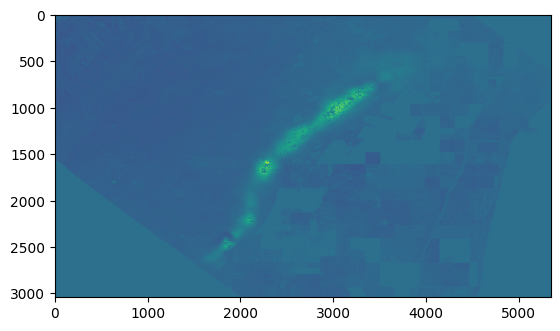

In [16]:
plt.imshow(grd_unw)

# 3. NISAR Sample Products
https://nisar.jpl.nasa.gov/data/sample-data/

* L2 GSLC 	Level 2 Focused SAR image in geocoded coordinates
* L2 GUNW 	Level 2 phase-unwrapped interferogram in geocoded coordinates

In [ ]:
#https://nisar.asf.alaska.edu/NISAR-SAMPLE-DATA/GSLC/ALOS1_Rosamond_20081012/NISAR_L2_PR_GSLC_001_005_A_219_2005_DHDH_A_20081127T060959_20081127T061015_P01101_F_N_J_001.h5
#https://nisar.asf.alaska.edu/NISAR-SAMPLE-DATA/GSLC/ALOS1_Rosamond_20081127/NISAR_L2_PR_GSLC_001_005_A_219_2005_DHDH_A_20081127T060959_20081127T061015_P01101_F_N_J_001.h5

#https://nisar.asf.alaska.edu/NISAR-SAMPLE-DATA/GUNW/ALOS-1_Rosamond_20081012_20081127/NISAR_L2_PR_GUNW_001_005_A_219_220_4020_SH_20081012T060910_20081012T060926_20081127T060959_20081127T061015_P01101_M_F_J_001.h5

In [ ]:
import h5py

## Other Resources

UAVSAR Data Download: https://uavsar.jpl.nasa.gov/cgi-bin/data.p

## References



1. Jones, C. E., An, K., Blom, R. G., Kent, J. D., Ivins, E. R., &amp; Bekaert, D. (2016). Anthropogenic and geologic influences on subsidence in the vicinity of New Orleans, Louisiana. Journal of Geophysical Research: Solid Earth, 121(5), 3867–3887. https://doi.org/10.1002/2015jb012636

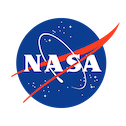

The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004)

© 2024. California Institute of Technology. Government sponsorship acknowledged.